In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
plt.rcParams["font.family"] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train=pd.read_excel('../第四问/样本数据.xlsx',index_col=0)
train.head()

,原料换热器管程总管进口温度,1.0MPa蒸汽进装置温度,氮气进装置流量,稳定塔顶压力,K101机出口压力,蒸汽进装置流量,加氢裂化轻石脑油进装置流量,辛烷值RON,硫含量
0,55.613933,196.993645,476.208445,0.652138,3.131928,1458.339950,6368.74700,90.6,3.2
1,56.461392,197.485060,453.687235,0.652110,3.131915,1142.179200,6360.64530,90.5,3.2
2,54.698909,201.774005,454.138060,0.652395,3.129382,1025.874790,6504.96490,90.7,3.2
3,57.883680,196.421215,467.951720,0.652089,3.130650,967.852340,6506.82495,90.4,3.2
4,57.303791,192.642635,470.470510,0.652213,3.128421,932.608515,6560.24225,89.6,3.2


In [3]:
#读取因变量
y=pd.read_excel('/Users/zhongrunping/Desktop/jupyter文件夹/数学建模/RON损失(不是变量).xlsx')[::-1].reset_index(drop=True)
y=y.iloc[:,2]
y

0      1.25
1      1.28
2      1.35
3      1.25
4      1.15
       ... 
320    1.28
321    1.38
322    1.38
323    1.18
324    1.38
Name: RON损失\n（不是变量）, Length: 325, dtype: float64

In [4]:
#训练模型
svr=SVR(kernel='poly',coef0=5,degree=3,cache_size=800).fit(train,y)
mean_absolute_error(y,svr.predict(train))
#训练平均的绝对误差0.15

0.15308364807468453

In [5]:
data=train.copy()
#硫含量大于5的 设置成5
data['硫含量']=data['硫含量'].apply(lambda x:5 if x>5 else x)
data=data.reset_index(drop=True)
len(data)

325

In [6]:
#硫和辛烷值的模型
value=pd.DataFrame(data.iloc[:,-2])  #辛烷值
sulfur=pd.DataFrame(data.iloc[:,-1])  #硫

Text(0, 0.5, '硫含量')

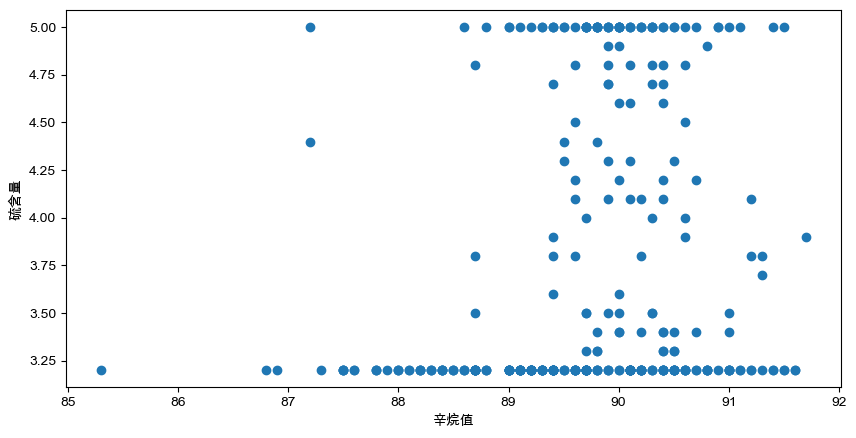

In [7]:
plt.figure(figsize=(10,5),dpi=100)
plt.scatter(value,sulfur)
plt.xlabel('辛烷值')
plt.ylabel(sulfur.columns[0])
plt.savefig('辛烷值和硫含量的散点图.png')

In [8]:
#用线性模型拟合
lr_reg=LinearRegression().fit(value,sulfur)
lr_reg.coef_[0],lr_reg.intercept_[0]  #系数和截距

(array([0.14751541]), -9.513898007280694)

In [9]:
#平均绝对误差
mean_absolute_error(sulfur,lr_reg.predict(value))

0.6308727692987519

In [10]:
sulfur_and_value=pd.DataFrame(lr_reg.predict(value),columns=['预测值'])
sulfur_and_value.insert(0,'实际值',sulfur)
sulfur_and_value.insert(0,'辛烷值',value)
sulfur_and_value.to_excel('辛烷值和硫含量的预测值和实际值.xlsx',index=None)

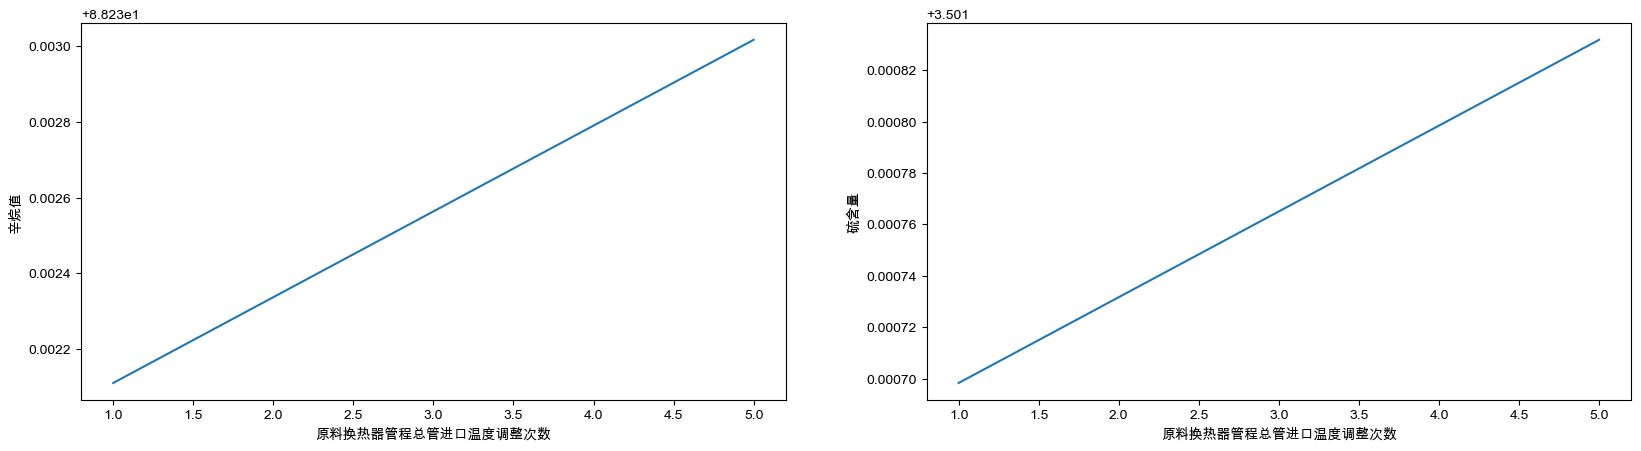

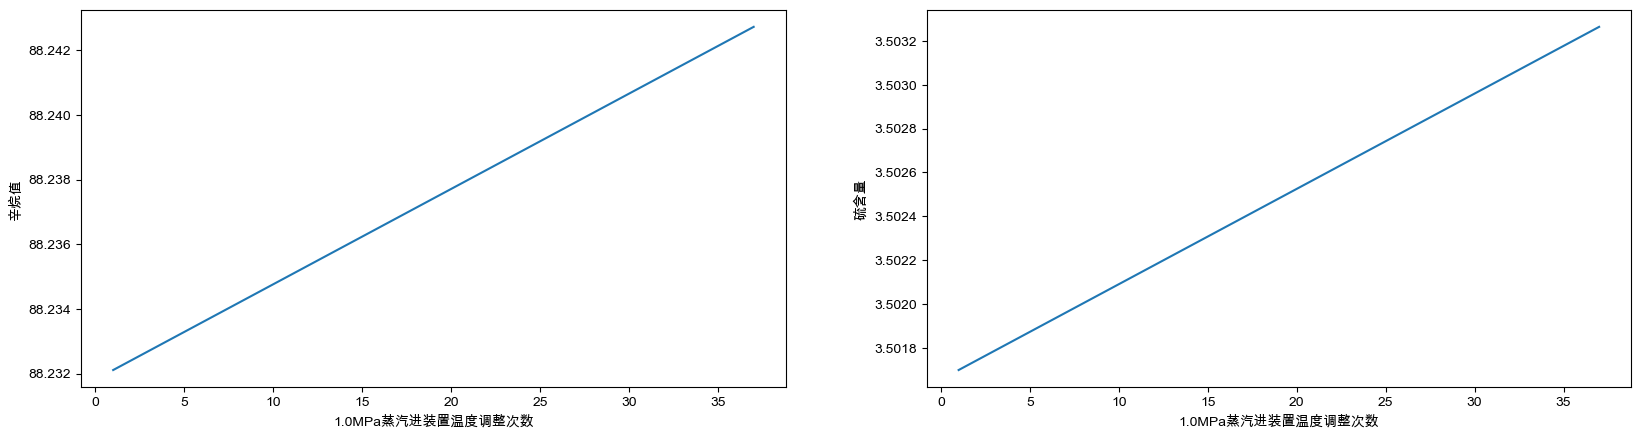

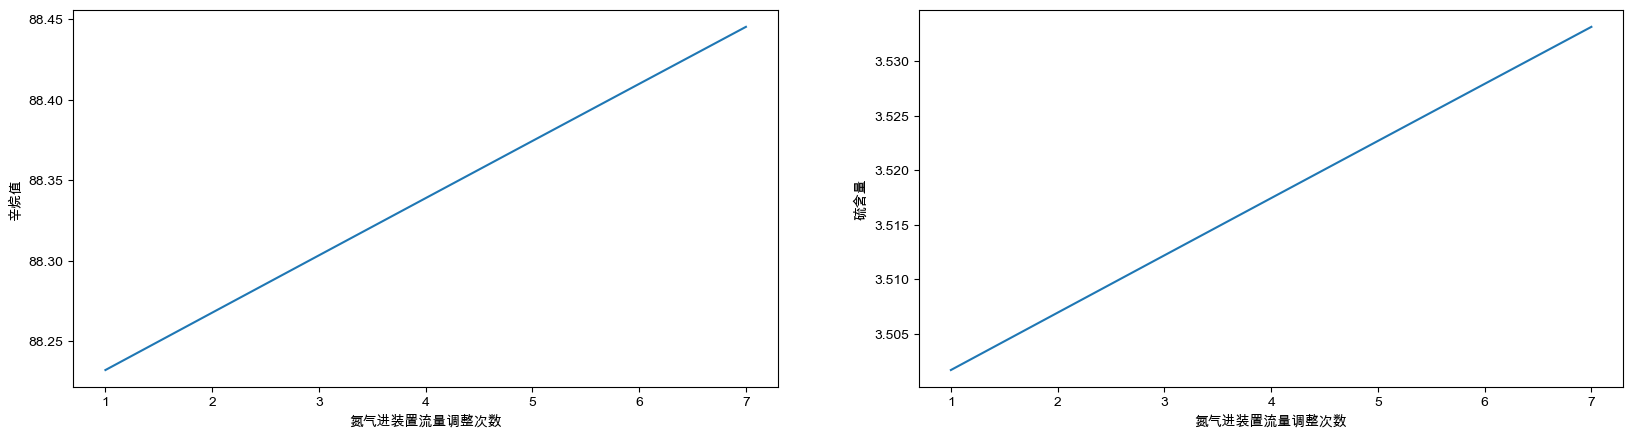

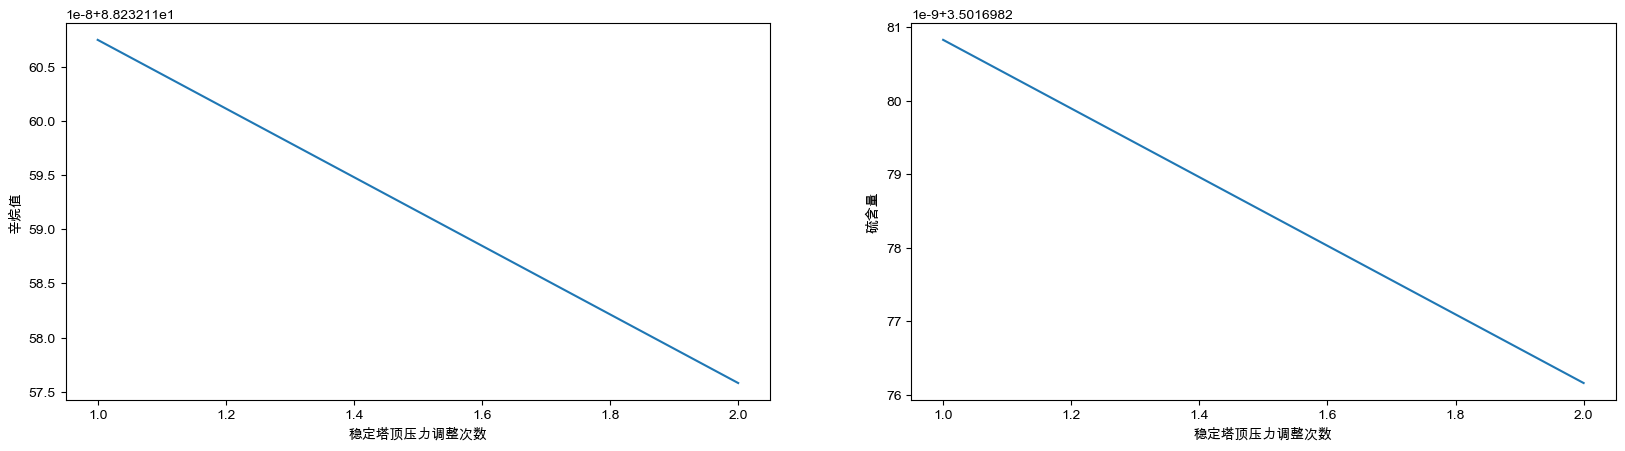

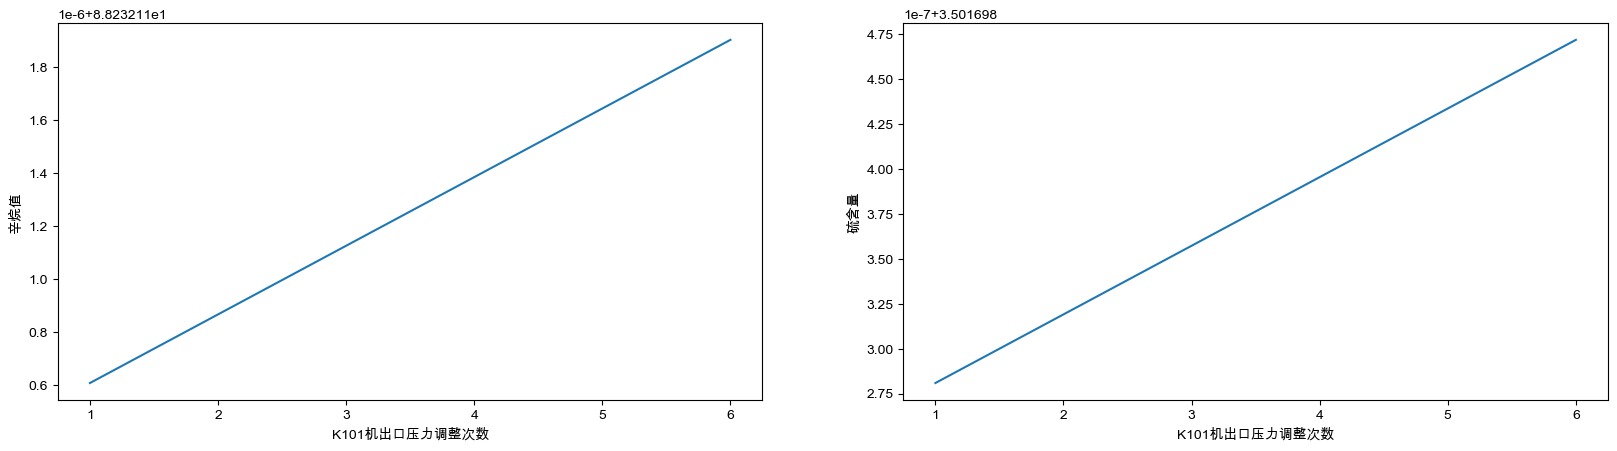

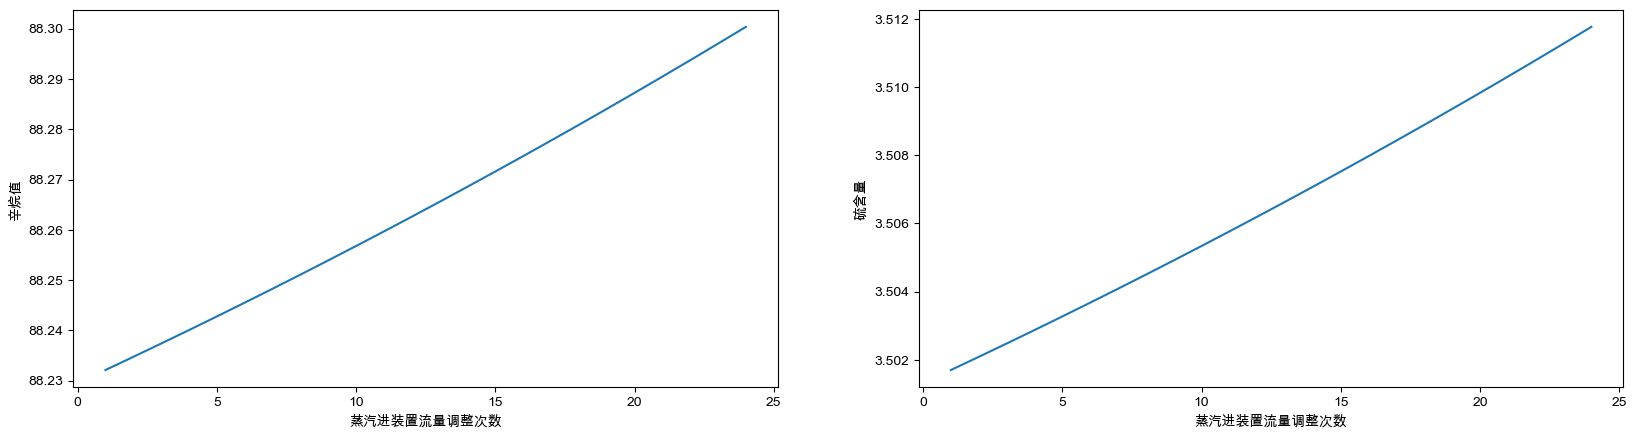

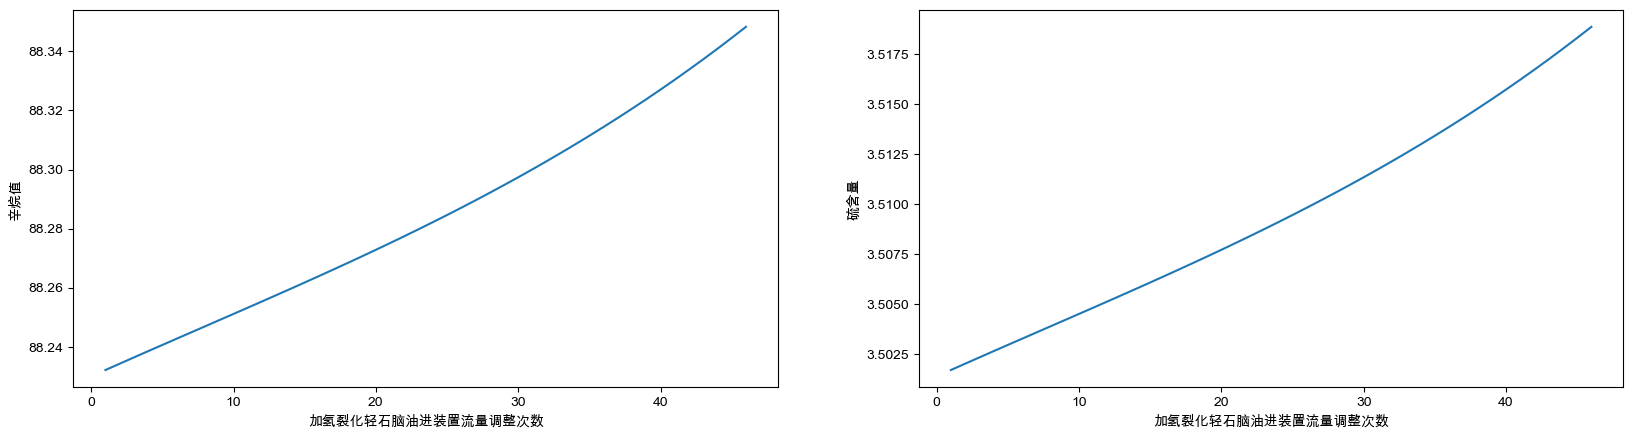

In [13]:
# 第一步 一个个调 读取变量调整过程
for i in range(7):
    process=pd.read_excel('各变量调整过程.xlsx',sheet_name=i).iloc[:,1:]
    result=svr.predict(process)
    process['预测的辛烷值损失']=result
    process['预测的辛烷值']=process['辛烷值1RON']-process['预测的辛烷值损失']
    process['预测的硫含量']=lr_reg.predict(np.array(process['预测的辛烷值']).reshape(-1,1))
    excel_name=train.columns[i]+'变化过程中硫含量和辛烷值'+'.xlsx'
    #process.to_excel(excel_name,index=None)  #写入本地
    plt.figure(figsize=(20,5),dpi=100) 
    plt.subplot(1,2,1)
    plt.plot(range(1,len(result)+1),process['预测的辛烷值'],label='辛烷值')
    plt.ylabel('辛烷值')
    plt.xlabel(train.columns[i]+'调整次数')
    plt.subplot(1,2,2)
    plt.plot(range(1,len(result)+1),process['预测的硫含量'],label='硫含量')
    plt.xlabel(train.columns[i]+'调整次数')
    plt.ylabel('硫含量')
    figure_name=train.columns[i]+'变化过程中硫和RON变化.png'
    plt.savefig(figure_name)

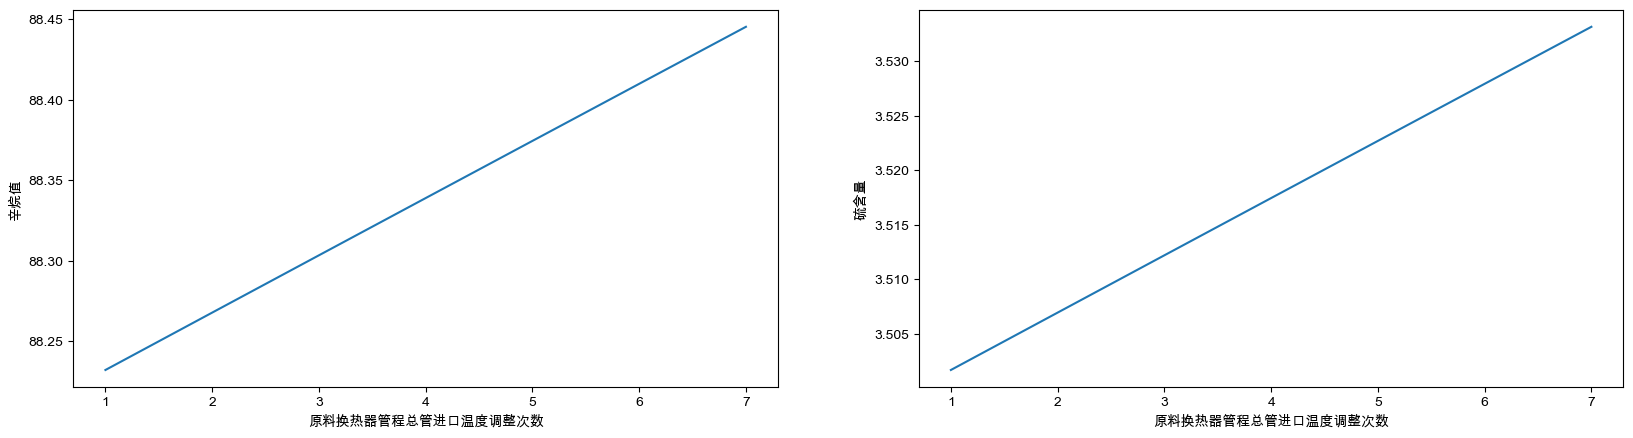

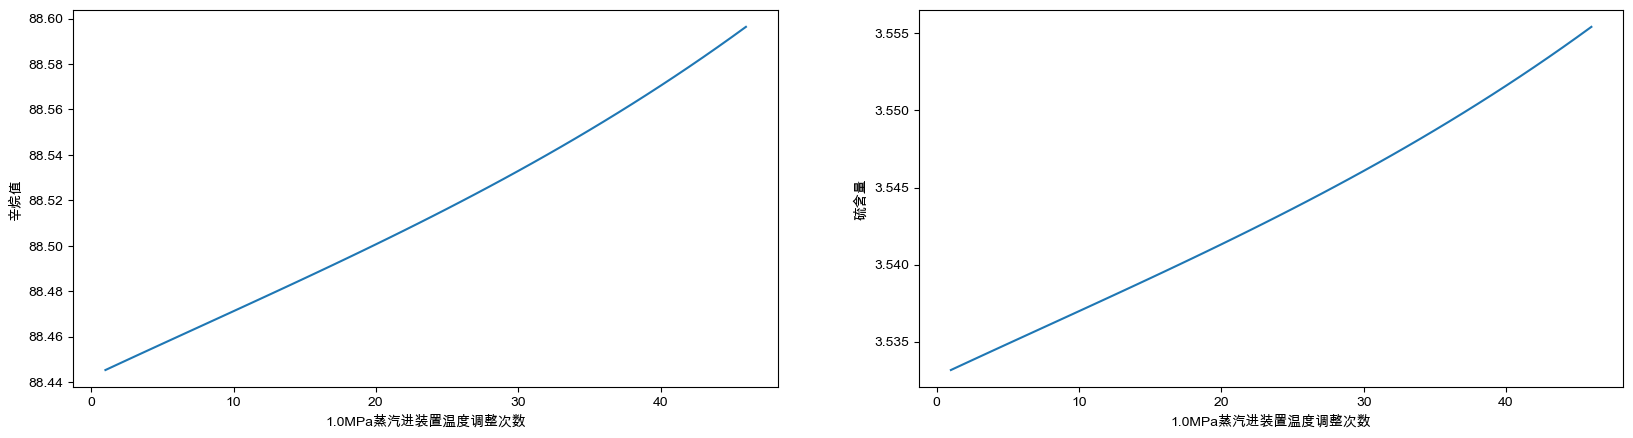

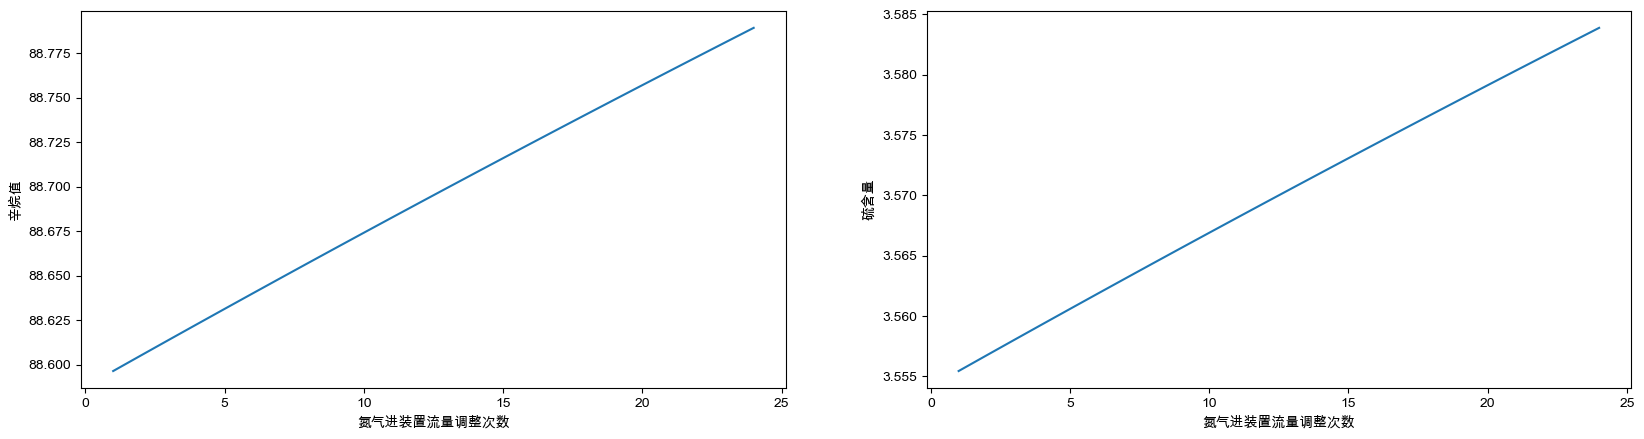

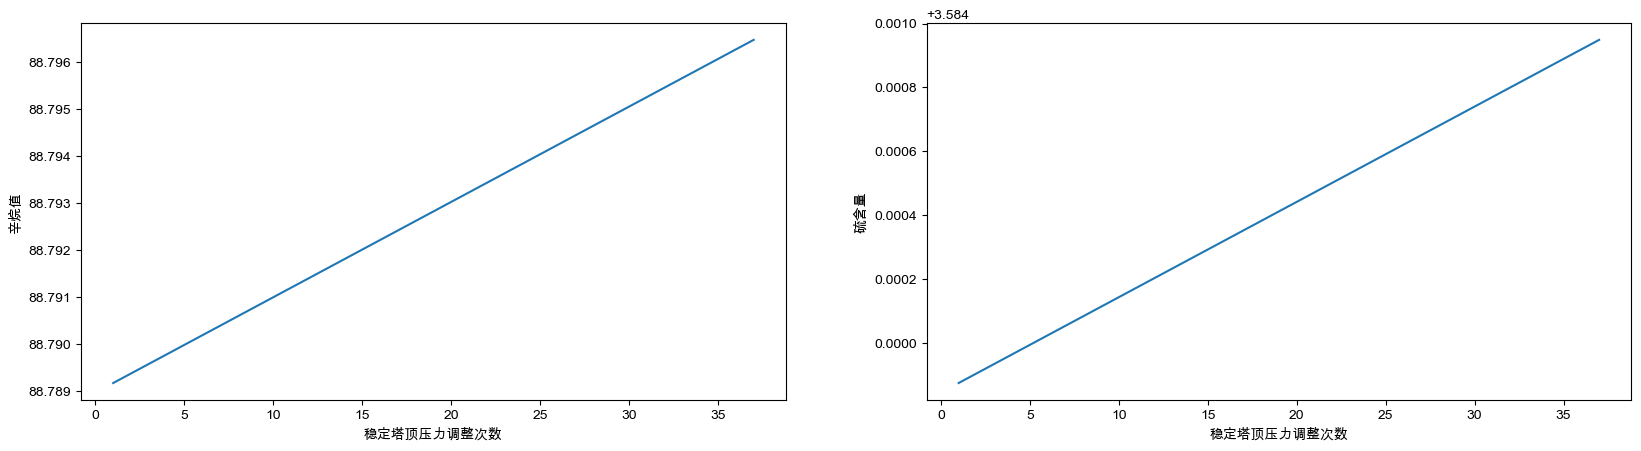

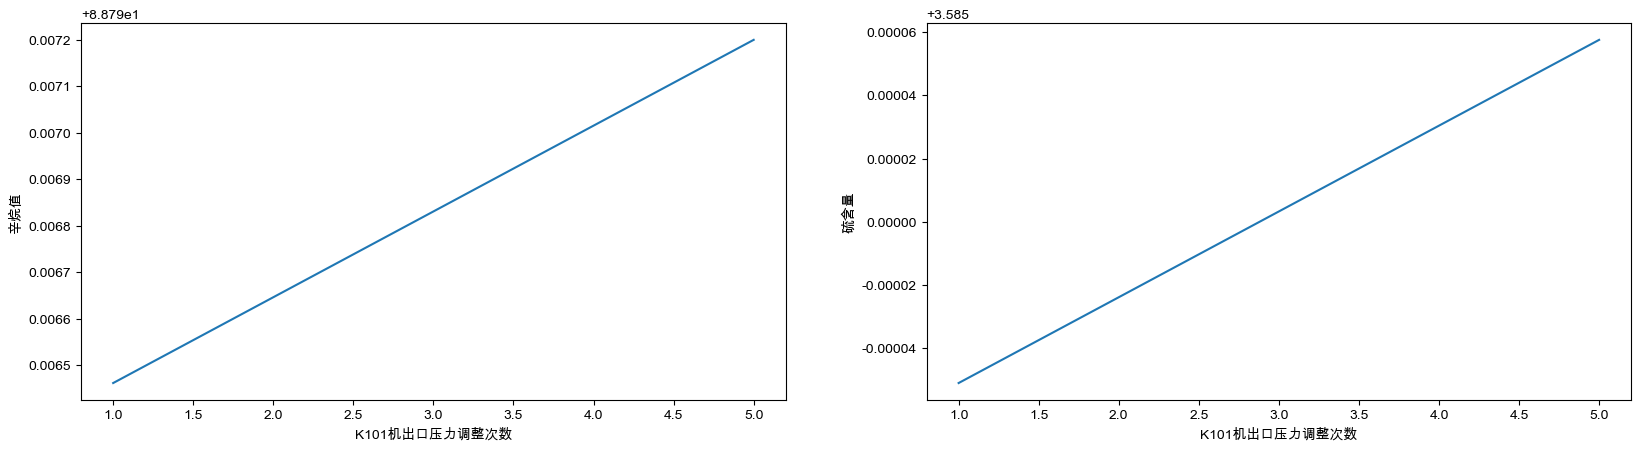

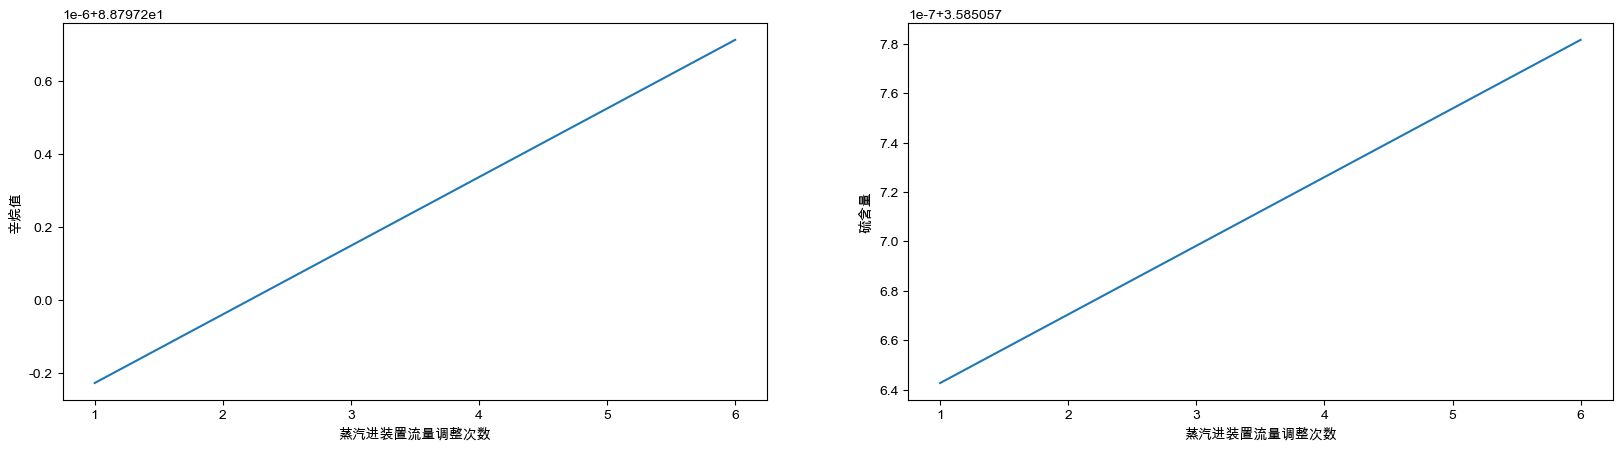

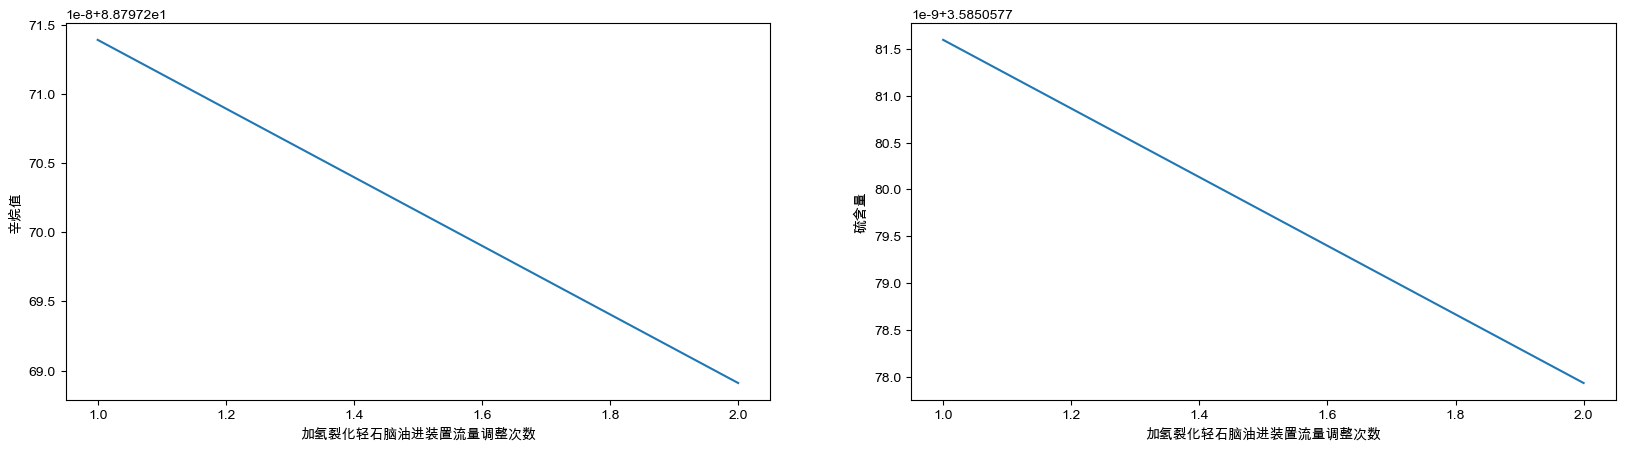

In [14]:
#第二步 从辛烷值最大的变量开始调整
final=pd.DataFrame()
for i in range(1,8):
    step=pd.read_excel('各个变量单独调整后预测的辛烷值和硫含量.xlsx',sheet_name=i).iloc[:,1:]
    result=svr.predict(step)
    step['预测的辛烷值损失']=result
    step['预测的辛烷值']=step['辛烷值1RON']-step['预测的辛烷值损失']
    step['预测的硫含量']=lr_reg.predict(np.array(step['预测的辛烷值']).reshape(-1,1))
    excel_name=train.columns[i]+'变化过程中硫含量和辛烷值'+'.xlsx'
    #process.to_excel(excel_name,index=None)  #写入本地
    final=pd.concat([final,step.iloc[-1:,:]],axis=0)
    plt.figure(figsize=(20,5),dpi=100) 
    plt.subplot(1,2,1)
    plt.plot(range(1,len(result)+1),step['预测的辛烷值'],label='辛烷值')
    plt.ylabel('辛烷值')
    plt.xlabel(train.columns[i-1]+'调整次数')
    plt.subplot(1,2,2)
    plt.plot(range(1,len(result)+1),step['预测的硫含量'],label='硫含量')
    plt.xlabel(train.columns[i-1]+'调整次数')
    plt.ylabel('硫含量')
    figure_name=train.columns[i-1]+'变化过程中硫和RON变化.png'
    plt.savefig(figure_name)
    #plt.show()

In [15]:
train.columns

Index(['原料换热器管程总管进口温度', '1.0MPa蒸汽进装置温度', '氮气进装置流量', '稳定塔顶压力', 'K101机出口压力',
       '蒸汽进装置流量', '加氢裂化轻石脑油进装置流量', '辛烷值RON', '硫含量'],
      dtype='object')